# Challenge Description 

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

In this competition, you’ll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information. You're free to explore any technique to create the most powerful model, from creating features to using the data in a more organic way within a model.

### Evaluation

The evaluation metric, M, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, G and default rate captured at 4%, D.

M = 0.5 * (G + D)

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics G and D, the negative labels are given a weight of 20 to adjust for downsampling. This metric has a maximum value of 1.0.

### Data exploration and Preprocessing
Dataset summary (from Kaggle):
- train_data.csv: 5.5M rows × 190+ features
- test_data.csv: 10M+ rows
- train_labels.csv: customer_id → target (0 or 1)
- Each customer has multiple monthly records → time-series panel dataset
- Features are aggregated customer metrics (balances, delinquencies, transactions, etc.)

Data categories:
- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

Categorical features: ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Task: for each customer_ID, the probability of a future payment default (target = 1). 


We use Raddar's data since its smaller (some processing already done):
- https://www.kaggle.com/code/raddar/amex-data-int-types-train
- https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data

What was done:
- The data type float (32bytes) was converted to int (8bytes) - therefore the column takes 4x less memory.
- Float format supports NA, but int does not support NA, so NA converted to -1 for positive only columns
- Categorical columns D_63 and D_64 were encoded

In [1]:
import pandas as pd

train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [28]:
# GARBAGE COLLECTION
import gc 
gc.collect()

0

In [3]:
# Check the parquet data
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 2.5+ GB


,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5.485466e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.531451e+06,4.510907e+06,5.529435e+06,5.529435e+06,791314.000000,3.873055e+06,...,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.429903e+06,944408.000000,5.531451e+06,5.490724e+06,5.531451e+06
mean,6.563343e-01,5.035986e+00,1.240101e-01,6.214890e-01,7.880273e-02,2.258454e-01,5.543458e-02,1.325390e-01,0.184974,1.546841e-01,...,-9.313243e-01,-9.644764e-01,-9.535646e-01,1.523781e-01,1.413933e-02,1.603911e-01,0.390799,1.522530e-01,5.238953e-02,6.007445e-01
std,2.446494e-01,9.181833e+00,2.119869e-01,4.014876e-01,2.263971e-01,1.933475e-01,2.037066e-01,2.349929e-01,0.228185,2.133977e-01,...,3.926067e-01,1.868469e-01,2.629447e-01,4.072783e-01,1.692060e-01,3.501590e-01,0.236182,4.071715e-01,1.825135e-01,2.119894e+00
min,-4.589548e-01,0.000000e+00,-7.588799e+00,9.192280e-09,1.534223e-09,-6.271321e-01,0.000000e+00,6.285293e-09,-0.000454,1.154550e-07,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-0.014539,-1.000000e+00,2.500991e-09,-1.000000e+00
25%,4.803307e-01,0.000000e+00,8.863645e-03,1.053313e-01,2.895934e-03,1.272588e-01,0.000000e+00,5.227570e-03,0.037516,4.227546e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.199399,0.000000e+00,2.752895e-03,0.000000e+00
50%,6.942950e-01,0.000000e+00,3.132968e-02,8.143328e-01,5.782230e-03,1.639082e-01,0.000000e+00,9.777229e-03,0.120519,8.851244e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.382136,0.000000e+00,5.508129e-03,0.000000e+00
75%,8.648159e-01,8.000000e+00,1.259019e-01,1.002403e+00,8.660590e-03,2.581017e-01,0.000000e+00,1.550507e-01,0.250869,1.843206e-01,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.559307,0.000000e+00,8.260448e-03,0.000000e+00
max,1.010000e+00,1.830000e+02,1.324060e+00,1.010000e+00,3.256284e+00,5.482888e+00,8.988807e+00,1.625262e+00,4.191119,1.011162e+01,...,7.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.339910e+00,2.229368,1.000000e+00,1.343331e+00,5.300000e+01


In [4]:
# There are still quite a few float32 columns, we want to inspect a few to understand what kind of values they have
float_cols = train.select_dtypes('float32').columns
train[float_cols].head()

,P_2,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_45,...,D_128,B_42,D_130,D_131,D_132,D_133,D_134,D_141,D_142,D_144
0,0.938469,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,NaN,0.708906,...,1.007819,NaN,0.0,0.0,NaN,0.004345,NaN,0.0,NaN,0.000610
1,0.936665,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,NaN,0.712795,...,1.004333,NaN,0.0,0.0,NaN,0.007495,NaN,0.0,NaN,0.005492
2,0.954180,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,NaN,0.720884,...,1.007831,NaN,0.0,0.0,NaN,0.009227,NaN,0.0,NaN,0.006986
3,0.960384,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,NaN,NaN,0.723997,...,1.003460,NaN,0.0,0.0,NaN,0.007206,NaN,0.0,NaN,0.006527
4,0.947248,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,NaN,NaN,0.720619,...,1.005053,NaN,0.0,0.0,NaN,0.006312,NaN,0.0,NaN,0.008126


In [5]:
# We want to denoise these float values by applying the common AMEX practice of converting float features to integer dtypes by scaling (×100) and encoding missing values as −1.
from tqdm import tqdm
import numpy as np

def denoise_floats(df):
    df = df.copy()
    float_cols = df.select_dtypes('float32').columns

    for col in tqdm(float_cols):
        # scale and floor first
        df[col] = np.floor(df[col] * 100)
        # fill missing AFTER scaling
        df[col] = df[col].fillna(-1).astype('int32')

    return df

train = denoise_floats(train)
test = denoise_floats(test)

100%|██████████| 93/93 [00:03<00:00, 29.87it/s]


In [6]:
# sanity check
train.info()
# Sanity: any NaNs left?
train.isna().any().any()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: int16(9), int32(93), int8(86), object(2)
memory usage: 2.5+ GB


np.False_

In [7]:
# Fraction of -1 per column (only for numeric)
numeric_cols = train.select_dtypes(include=['int16', 'int32', 'int8']).columns.drop(['customer_ID'], errors='ignore')

print("After converting floats to scaled integers and encoding missing values as −1, several features still have high missingness (up to 99%), which suggests they may be sparsely observed behavioral variables.")
print("This will influence feature selection and aggregation strategy.")
missing_frac = (train[numeric_cols] == -1).mean().sort_values(ascending=False)
missing_frac.head(20)

After converting floats to scaled integers and encoding missing values as −1, several features still have high missingness (up to 99%), which suggests they may be sparsely observed behavioral variables.
This will influence feature selection and aggregation strategy.


D_87     0.999301
D_88     0.998915
D_108    0.994768
D_110    0.994344
D_111    0.994335
B_39     0.993945
D_73     0.989941
B_42     0.987078
D_134    0.964972
D_138    0.964801
D_137    0.964801
D_136    0.964801
D_135    0.964801
R_9      0.943499
B_29     0.931046
D_132    0.902208
D_106    0.902133
D_49     0.901376
R_26     0.889847
D_76     0.887462
dtype: float64

In [9]:
# Load labels
labels = pd.read_csv("data/train_labels.csv")
labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [10]:
import matplotlib.pyplot as plt

# Target distribution
labels['target'].value_counts(normalize=True)


target
0    0.741066
1    0.258934
Name: proportion, dtype: float64

The dataset is imbalanced, with ~26% defaulters (target = 1) and ~74% non-defaulters (target = 0), which motivates using imbalance-aware metrics and possibly class-weighted models

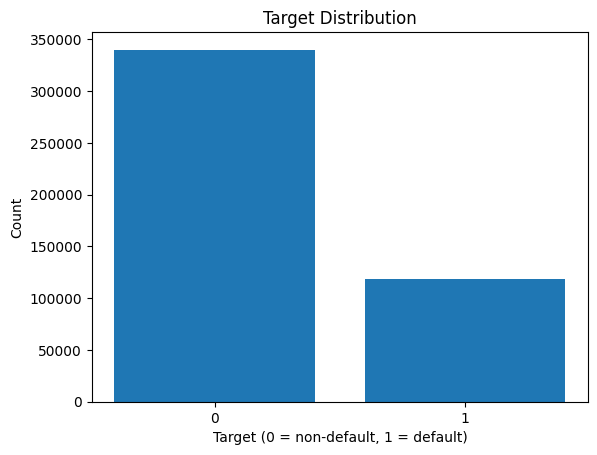

In [11]:
target_counts = labels['target'].value_counts()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.xlabel("Target (0 = non-default, 1 = default)")
plt.ylabel("Count")
plt.title("Target Distribution")
plt.show()

### Understand the time-series structure per customer

Check how many records (months) each customer_ID has and whether S_2 behaves like a monthly timeline.

EDA below shows that most customers have approximately 13 monthly records, confirming the panel time-series structure described in the competition

In [12]:
# Number of rows per customer
seq_len = train.groupby("customer_ID")["S_2"].nunique()
seq_len.describe()

count    458913.000000
mean         12.053376
std           2.610273
min           1.000000
25%          13.000000
50%          13.000000
75%          13.000000
max          13.000000
Name: S_2, dtype: float64

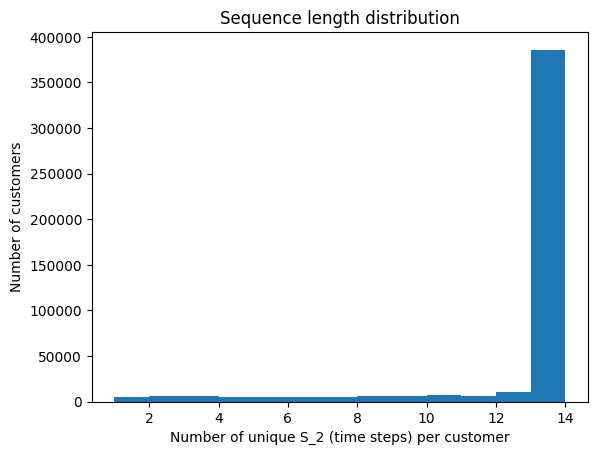

In [13]:
plt.hist(seq_len, bins=range(int(seq_len.min()), int(seq_len.max()) + 2))
plt.xlabel("Number of unique S_2 (time steps) per customer")
plt.ylabel("Number of customers")
plt.title("Sequence length distribution")
plt.show()

In [14]:
# Check if all categorical features have been encoded in Raddar's data
CATEGORICAL_FEATURES = [
    'B_30', 'B_38', 'D_114', 'D_116', 'D_117',
    'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'
]

train[CATEGORICAL_FEATURES].dtypes, train[CATEGORICAL_FEATURES].nunique()

(B_30     int8
 B_38     int8
 D_114    int8
 D_116    int8
 D_117    int8
 D_120    int8
 D_126    int8
 D_63     int8
 D_64     int8
 D_66     int8
 D_68     int8
 dtype: object,
 B_30     4
 B_38     8
 D_114    3
 D_116    3
 D_117    8
 D_120    3
 D_126    4
 D_63     6
 D_64     5
 D_66     3
 D_68     8
 dtype: int64)

In [15]:
# check feature groups
feature_groups = (
    train.columns.to_series()
    .loc[lambda s: s.str.contains('_')]  # skip customer_ID, S_2
    .str.extract(r'(^[A-Z]_)')[0]
    .value_counts()
)

feature_groups

0
D_    96
B_    40
R_    28
S_    22
P_     3
Name: count, dtype: int64

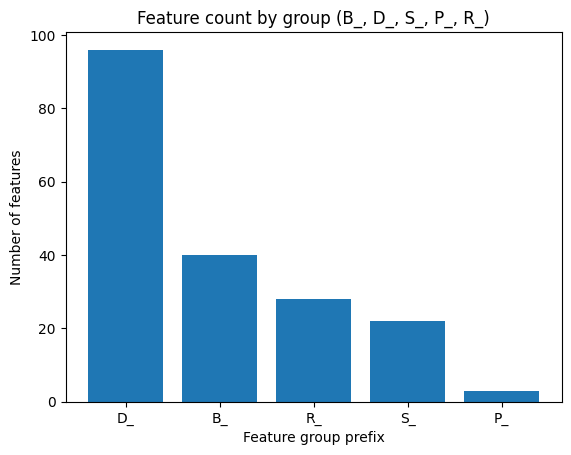

In [16]:
plt.bar(feature_groups.index, feature_groups.values)
plt.xlabel("Feature group prefix")
plt.ylabel("Number of features")
plt.title("Feature count by group (B_, D_, S_, P_, R_)")
plt.show()

### First look at differences between defaulters & non-defaulters

In [17]:
# use sample to speed up the notebook
sample = train.sample(50000, random_state=42)

# merge sample with labels and pick a very simple aggregation: the last observation per customer, to compare defaulters vs non-defaulters on a few key features.
sample_ids = sample["customer_ID"].unique()
labels_subset = labels[labels["customer_ID"].isin(sample_ids)]

sample_merged = sample.merge(labels_subset, on="customer_ID", how="left")
sample_merged.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,b9cdf83627a38ebbfd8b8eb2c943f631fa18ea56731951...,2018-02-14,80,0,0,81,0,-1,0,0,...,-1,-1,0,0,0,-1,0,0,0,0
1,0b1ecd1e9fd72ebf6e3188c581e90de0210c1d3133b231...,2017-07-08,100,0,0,81,0,-1,0,0,...,-1,-1,0,0,0,-1,0,0,0,0
2,191091b92233586dde76a982176a9f9e25a2c39640de2d...,2017-12-20,86,0,0,81,0,-1,0,0,...,-1,-1,0,0,0,-1,0,0,0,0
3,84405a24538c7f1c023c05e613e5a1332880034c594813...,2017-11-11,60,1,25,1,0,25,0,21,...,-1,-1,1,1,89,13,1,0,1,0
4,f8c0112a130a70118e9b4c3442516f2853bcd01b4fd715...,2017-12-21,99,0,0,81,0,-1,0,0,...,-1,-1,0,0,0,-1,0,0,0,0


In [18]:
# Last observation per customer (by S_2)
last_obs = (
    sample_merged.sort_values(["customer_ID", "S_2"])
    .groupby("customer_ID")
    .tail(1)
)

last_obs.shape

(47397, 191)

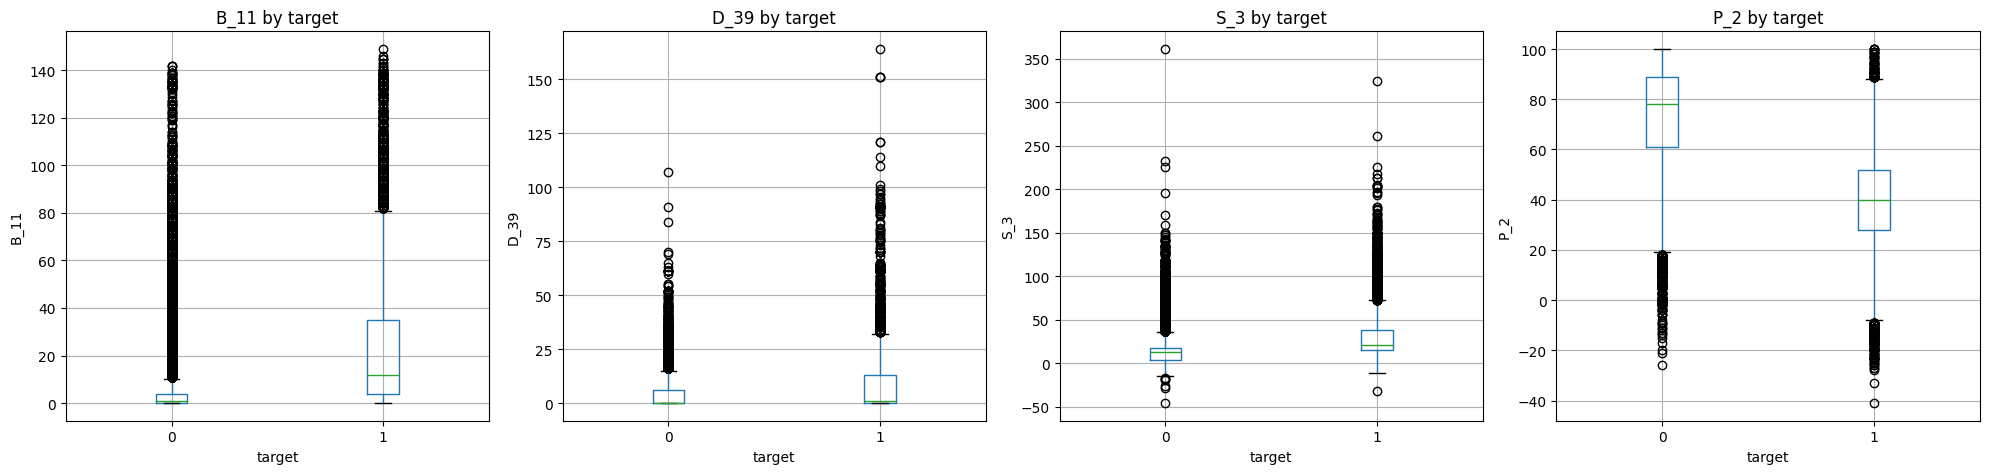

In [19]:
import matplotlib.pyplot as plt

features_to_plot = ["B_11", "D_39", "S_3", "P_2"]  # ADJUSTABLE
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, f in enumerate(features_to_plot):
    last_obs.boxplot(column=f, by="target", ax=axes[i])
    axes[i].set_title(f"{f} by target")
    axes[i].set_xlabel("target")
    axes[i].set_ylabel(f)

plt.suptitle("")  # This removes the automatic suptitle
plt.tight_layout()
plt.show()

In [20]:
# Save pre-aggregation checkpoint
train.to_parquet("data/train_preagg.parquet")
test.to_parquet("data/test_preagg.parquet")

print("Checkpoint saved! You can safely restart from here.")

Checkpoint saved! You can safely restart from here.


### Customer-level aggregation
The competition’s target is per customer, not per row. We need aggregated features before any model

**Goal**: Collapse the time-series (monthly records) into one row per customer using mean, std, last, and trend

Initially, we attempted NaN-aware aggregation (replacing sentinel −1 with NaN prior to computing per-customer means and standard deviations). However, due to memory constraints on local hardware (10M×190 test set), this approach led to MemoryError. We therefore adopted a more memory-efficient strategy: keeping −1 as a dedicated missing indicator, aggregating directly, and enriching the feature space with temporal deltas and ratios (e.g., last vs. mean). This approach balances practical constraints with model performance

In [27]:
train = pd.read_parquet("data/train_preagg.parquet")
test = pd.read_parquet("data/test_preagg.parquet")

### Lag-1 difference features (last - previous month)
Inspired by Ragnar’s AMEX solution, we add one more temporal feature type: for each numeric feature and each customer, we compute the difference between the last month and the previous month (`last - lag1`).

This captures short-term shocks in behaviour (e.g., sudden increase in balance or delinquency), which is often highly predictive of default.

For balances / delinquencies:
- Sharp increase in debt or delinquency in the final month → high risk.
- Sudden drop in payments or spend can also be bad.
- It captures abrupt recent deterioration, which is often more predictive than the long history

These features are added as `<feature>_diff1` columns at the customer level.

In [32]:
# All columns except IDs / date 
base_features = [c for c in train.columns if c not in ['customer_ID', 'S_2']]
# Numeric features only
num_features = [c for c in base_features if c not in CATEGORICAL_FEATURES]

print(f"Total base features: {len(base_features)}")
print(f"Numeric features: {len(num_features)}")

def get_last_diff1(df, num_cols): 
    """ 
    For each customer_ID, compute the last first-order difference for the given numeric columns: diff1 = x_last - x_previous 
    
    Returns a customer-level dataframe with columns '<col>_diff1'. 
    """
    df_sorted = df.sort_values(['customer_ID', 'S_2'])
    diff_rows = [] 
    cust_ids = [] 
    
    # groupby customer and compute diff1 on the time axis 
    for cid, g in tqdm(df_sorted.groupby('customer_ID'), desc="Computing last diff1"): 
        # first-order diff along time 
        diff = g[num_cols].diff(1) 

        # take the last row (corresponding to last month) 
        last_diff = diff.iloc[[-1]].values.astype(np.float32)
        diff_rows.append(last_diff)
        cust_ids.append(cid)

    # stack into array and then DataFrame
    diff_array = np.concatenate(diff_rows, axis=0) 
    diff_df = pd.DataFrame(diff_array, columns=[f"{c}_diff1" for c in num_cols])
    diff_df['customer_ID'] = cust_ids
    return diff_df
    
# Compute lag-1 difference features for train and test 
train_diff1 = get_last_diff1(train, num_features)
test_diff1 = get_last_diff1(test, num_features)

train_diff1.head()

Total base features: 188
Numeric features: 177


Computing last diff1: 100%|██████████| 924621/924621 [03:30<00:00, 4384.87it/s]


,P_2_diff1,D_39_diff1,B_1_diff1,B_2_diff1,R_1_diff1,S_3_diff1,D_41_diff1,B_3_diff1,D_42_diff1,D_43_diff1,...,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1,customer_ID
0,0.0,0.0,-1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1,1.0,-12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
3,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...


### Expanding feature set
Some new features which capture more of the trajectory:
- first: who the customer was when they first appeared — initial risk level
- last - first: how much the feature moved from “start” to “now”. Big positive change in things like delinquency / balances = bad.
- last / first: relative change; e.g., balance doubled vs. 5% increase.

We end up modelling:
- Level → last
- Short-term shock → last - lag1 (you added _diff1)
- Long-term drift → last - mean, last - first
- Relative drift → last / mean, last / first

For a credit-risk panel like this, these are exactly the story features the model needs.

In [33]:
# Each customer has 13–14 monthly records. To model at the customer level, we aggregated all numeric features using mean, standard deviation, first and the last observation

def aggregate_per_customer(df): 
    # Only aggregate feature columns, not S_2 / customer_ID 
    feature_cols = [c for c in df.columns if c not in ['customer_ID', 'S_2']] 
    agg_funcs = ['mean', 'std', 'first', 'last'] 
    out = df.groupby('customer_ID')[feature_cols].agg(agg_funcs) 
    out.columns = ['_'.join(col) for col in out.columns] 
    out.reset_index(inplace=True) 
    return out 

# Aggregate 
train_agg = aggregate_per_customer(train) 
test_agg = aggregate_per_customer(test) 

# Add lag-1 difference features (each is already customer-level) 
train_agg = train_agg.merge(train_diff1, on='customer_ID', how='left') 
test_agg = test_agg.merge(test_diff1, on='customer_ID', how='left') 

# Merge with target 
labels = pd.read_csv("data/train_labels.csv") 
train_agg = train_agg.merge(labels, on='customer_ID', how='left') 

train_agg.shape

/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/1562767416.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out.reset_index(inplace=True)
/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/1562767416.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out.reset_index(inplace=True)


(458913, 931)

In [34]:
# expand feature set using deltas between last and mean
def add_delta_features(df):
    """
    Takes a customer-level aggregated dataframe (e.g. train_agg / test_agg)
    that has columns like 'B_11_mean', 'B_11_std', 'B_11_last', and
    adds:
        - '<base>_last_mean_diff'
        - '<base>_last_mean_ratio'
    in-place, then returns the same dataframe.
    """
    new_cols = {}
    for col in df.columns:
        if col.endswith('_last'):
            base = col[:-5]
            mean_col = f'{base}_mean'
            if mean_col in df.columns:
                new_cols[f'{base}_last_mean_diff'] = df[col] - df[mean_col]
                new_cols[f'{base}_last_mean_ratio'] = (df[col] + 1e-6) / (df[mean_col] + 1e-6)
    for name, series in new_cols.items():
        df[name] = series
    return df

train_agg = add_delta_features(train_agg)
test_agg = add_delta_features(test_agg)

/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/2643534834.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = series
/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/2643534834.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = series
/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/2643534834.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [35]:
def add_first_last_interactions(df):
    new_cols = {}
    for col in df.columns:
        if col.endswith('_last'):
            base = col[:-5]          # strip "_last"
            first_col = f'{base}_first'
            if first_col in df.columns:
                last_series = df[col].astype(float)
                first_series = df[first_col].astype(float)

                new_cols[f'{base}_last_first_diff'] = last_series - first_series
                new_cols[f'{base}_last_first_ratio'] = (last_series + 1e-6) / (first_series + 1e-6)

    for name, series in new_cols.items():
        df[name] = series

    return df

train_agg = add_first_last_interactions(train_agg)
test_agg  = add_first_last_interactions(test_agg)

/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/1877700582.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = series
/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/1877700582.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = series
/var/folders/cq/9s7nnph509nd7vx088r72xtm0000gn/T/ipykernel_24547/1877700582.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [37]:
# Sanity check
train_agg.shape,test_agg.shape 


((458913, 1683), (924621, 1682))

In [38]:
# Sanity check 
print("\nTrain aggregated dataset columns:") 
print(train_agg.columns.tolist())


Train aggregated dataset columns:
['customer_ID', 'P_2_mean', 'P_2_std', 'P_2_first', 'P_2_last', 'D_39_mean', 'D_39_std', 'D_39_first', 'D_39_last', 'B_1_mean', 'B_1_std', 'B_1_first', 'B_1_last', 'B_2_mean', 'B_2_std', 'B_2_first', 'B_2_last', 'R_1_mean', 'R_1_std', 'R_1_first', 'R_1_last', 'S_3_mean', 'S_3_std', 'S_3_first', 'S_3_last', 'D_41_mean', 'D_41_std', 'D_41_first', 'D_41_last', 'B_3_mean', 'B_3_std', 'B_3_first', 'B_3_last', 'D_42_mean', 'D_42_std', 'D_42_first', 'D_42_last', 'D_43_mean', 'D_43_std', 'D_43_first', 'D_43_last', 'D_44_mean', 'D_44_std', 'D_44_first', 'D_44_last', 'B_4_mean', 'B_4_std', 'B_4_first', 'B_4_last', 'D_45_mean', 'D_45_std', 'D_45_first', 'D_45_last', 'B_5_mean', 'B_5_std', 'B_5_first', 'B_5_last', 'R_2_mean', 'R_2_std', 'R_2_first', 'R_2_last', 'D_46_mean', 'D_46_std', 'D_46_first', 'D_46_last', 'D_47_mean', 'D_47_std', 'D_47_first', 'D_47_last', 'D_48_mean', 'D_48_std', 'D_48_first', 'D_48_last', 'D_49_mean', 'D_49_std', 'D_49_first', 'D_49_last

In [24]:
# Save aggregated data
train_agg.to_parquet("data/train_agg.parquet")
test_agg.to_parquet("data/test_agg.parquet")
print("Aggregated data saved!")

KeyboardInterrupt: 

### Build a simple baseline model

Train a simple baseline (e.g. LightGBM) using these aggregated features to get an early leaderboard-style score to measure progress

LightGBM is fast, robust, and perfect for this stage.

In [36]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_full = train_agg.drop(columns=['customer_ID', 'target'])
y = train_agg['target']

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt', # try dart later
    'num_leaves': 64,
    'learning_rate': 0.01,
    'feature_fraction': 0.2,
    'bagging_freq': 5,
    'bagging_fraction': 0.1,
    'max_depth': -1,
    'min_data_in_leaf': 100, # try 2048
    'lambda_l1': 2,
    'lambda_l2': 2,
    'n_estimators': 5000,
    'n_jobs': -1,
    'verbose': -1,
    'early_stopping_rounds': 200
}

# initial training on all features
model_full = LGBMClassifier(**lgb_params)
model_full.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
)


# 2. Get feature importances
feat_imp = pd.DataFrame({
    'feature': X_full.columns,
    'importance': model_full.feature_importances_
})

dead_feats = feat_imp.loc[feat_imp['importance'] == 0, 'feature'].tolist()
print(f"Number of dead features: {len(dead_feats)}")


Number of dead features: 67


In [37]:

# 3. Build reduced feature matrices (drop dead features from BOTH train and test)
keep_feats = [f for f in X_full.columns if f not in dead_feats]

X_train_r = X_train[keep_feats]
X_val_r   = X_val[keep_feats]
X_test_r  = test_agg[keep_feats]  # test_agg must have same columns

# 4. Retrain model on reduced features
model = LGBMClassifier(**lgb_params)
model.fit(
    X_train_r, y_train,
    eval_set=[(X_val_r, y_val)],
    eval_metric='auc',
)

# 5. Evaluate on reduced validation set
preds_val = model.predict_proba(X_val_r)[:, 1]
print("AUC with reduced features:", roc_auc_score(y_val, preds_val))

AUC with reduced features: 0.9629972723737946


In [73]:
submission_lgb_cv = pd.DataFrame({
    'customer_ID': test_agg['customer_ID'],
    'prediction': lgb_cv_test_pred,
})

submission_lgb_cv.to_csv("submission_lgb_cv.csv", index=False)
submission_lgb_cv.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.022021
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000917
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.041321
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.152152
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.893047


In [38]:
# try baseline model on test set
preds_test = model.predict_proba(X_test_r)[:, 1]

KeyboardInterrupt: 

In [43]:
from catboost import CatBoostClassifier
# CatBoost: use same split as LGBM
cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=True
)

cat.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)

# validation preds
cat_val = cat.predict_proba(X_val)[:, 1]
cat_test = cat.predict_proba(test_agg.drop(columns=['customer_ID']))[:, 1]

print("CatBoost AUC:", roc_auc_score(y_val, cat_val))

0:	test: 0.9338586	best: 0.9338586 (0)	total: 683ms	remaining: 11m 22s
1:	test: 0.9408196	best: 0.9408196 (1)	total: 1.35s	remaining: 11m 13s
2:	test: 0.9433061	best: 0.9433061 (2)	total: 1.95s	remaining: 10m 46s
3:	test: 0.9456182	best: 0.9456182 (3)	total: 2.59s	remaining: 10m 45s
4:	test: 0.9465435	best: 0.9465435 (4)	total: 3.25s	remaining: 10m 46s
5:	test: 0.9478061	best: 0.9478061 (5)	total: 3.92s	remaining: 10m 49s
6:	test: 0.9481147	best: 0.9481147 (6)	total: 4.59s	remaining: 10m 50s
7:	test: 0.9483807	best: 0.9483807 (7)	total: 5.31s	remaining: 10m 58s
8:	test: 0.9486824	best: 0.9486824 (8)	total: 5.94s	remaining: 10m 54s
9:	test: 0.9490738	best: 0.9490738 (9)	total: 6.53s	remaining: 10m 46s
10:	test: 0.9493080	best: 0.9493080 (10)	total: 7.17s	remaining: 10m 45s
11:	test: 0.9494698	best: 0.9494698 (11)	total: 7.82s	remaining: 10m 43s
12:	test: 0.9498746	best: 0.9498746 (12)	total: 8.46s	remaining: 10m 42s
13:	test: 0.9500015	best: 0.9500015 (13)	total: 9.17s	remaining: 10m 45

In [ ]:
# =========================================================
# LightGBM DART model (single split, fast-ish)
# =========================================================

# Hyper params taken from https://github.com/jxzly/Kaggle-American-Express-Default-Prediction-1st-solution/blob/master/S5_LGB_main.py
dart_params = {
    'objective': 'binary',
    'metric' : 'binary_logloss',
    'boosting_type': 'dart',
    'num_leaves': 64,          
    'learning_rate': 0.035,
    'feature_fraction' : 0.05,
    'bagging_fraction' : 0.75,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_data_in_leaf': 256,
    'lambda_l1': 0.1,
    'lambda_l2': 30,
    'n_estimators': 3000,
    'n_jobs': -1,
    'verbose': 1,
}

dart_model = LGBMClassifier(**dart_params)

dart_model.fit(
    X_train_r, y_train,
    eval_set=[(X_val_r, y_val)],
    eval_metric='binary_logloss',
)

dart_val = dart_model.predict_proba(X_val_r)[:, 1]
dart_test = dart_model.predict_proba(X_test_r)[:, 1]

print("DART LGBM AUC:", roc_auc_score(y_val, dart_val))

In [ ]:
# quick submission variations
for weights, name in [((0.25,0.05,0.75),"A"), # best 3-way blend for single-fold LGBM + CAT + DART
                      ((0.40,0.0,0.60),"B") ]:

    w_lgb, w_cat, w_dart = weights
    blended = (
        w_lgb  * preds_test +
        w_cat  * cat_test +
        w_dart * dart_test
    )

    sub = pd.DataFrame({
        'customer_ID': test_agg['customer_ID'],
        'prediction': blended,
    })
    sub.to_csv(f"submission_{name}.csv", index=False)
    print(f"Saved submission_{name}.csv with weights {weights}")


### K-Folds Models

In [ ]:
# To improve generalisation and reduce the risk of overfitting to a single random train/validation split, 
# we replace the hold-out split with 5-fold GroupKFold cross-validation on `customer_ID`. 
# For each fold, we train a LightGBM model and ensemble their predictions on the test set by averaging.

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Use the reduced feature set (after dropping dead features)
X = train_agg[keep_feats]
y = train_agg['target'].values
groups = train_agg['customer_ID'].values

X_test_cv = test_agg[keep_feats]

gkf = GroupKFold(n_splits=5)

oof_preds = np.zeros(len(X))
test_preds_folds = np.zeros((len(X_test_cv), 5))

cv_lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 255,
    'learning_rate': 0.01,
    'feature_fraction': 0.25,
    'bagging_fraction': 0.25,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 80,
    'lambda_l1': 2,
    'lambda_l2': 2,
    'n_estimators': 10000,
    'n_jobs': -1,
    'verbose': -1,
    'early_stopping_rounds': 100
}

lgbm_models = []

for fold, (trn_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n===== Fold {fold+1} =====")
    X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_tr, y_val = y[trn_idx], y[val_idx]

    model_cv = LGBMClassifier(**cv_lgb_params)

    model_cv.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
    )

    # OOF predictions
    oof_preds[val_idx] = model_cv.predict_proba(X_val)[:, 1]
    # Test predictions for this fold
    test_preds_folds[:, fold] = model_cv.predict_proba(X_test_cv)[:, 1]

    lgbm_models.append(model_cv)

# Overall OOF AUC
oof_auc = roc_auc_score(y, oof_preds)
print(f"\nOOF AUC (5-fold GroupKFold): {oof_auc:.6f}")

# Average predictions across folds
lgb_cv_val = oof_preds.mean(axis=0)
lgb_cv_test_pred = test_preds_folds.mean(axis=1)



===== Fold 1 =====

===== Fold 2 =====

===== Fold 3 =====

===== Fold 4 =====

===== Fold 5 =====

OOF AUC (5-fold GroupKFold): 0.962065


Initial setup:
- Aggregations: mean, std, last
- Model: LightGBM, default hyperparameters
- Features: ~563 columns (one per feature×stat)

Gives a baseline public score of 0.78848

2nd improvement: added ratio and delta features
Score: 0.79068

3rd improvement: try different LightGBM params
Score: 0.79269

4th improvement: drop dead features
Score: 0.79295

5th improvement: add catboost, simple 0.7 to 0.3 blend
Score: 0.79362 

6th (minor) improvement: find best blend 
Score: 0.79361

7th improvement: 5-fold cv (simplified)
Score: 0.79667

8th (minor) improvement: hardcoded blend of 0.8 to 0.2 (CAT) 
Score: 0.79671

9th improvement: add new features (first, first lag, first/last etc.)
Score: 0.79492 **compare to 6th improvement

10th improvement: with DART blend with LGBM
Score: 0.79658

11th improvement: best 3-way blend: (0.25, 0.05, 0.7)
Score: 0.79670
